In [1]:
import starepandas
import geopandas
import pystare
import pickle
import numpy
import geopandas
import matplotlib.pyplot as plt
import datetime
import rasterio
import pandas
import sqlalchemy
import cartopy

In [3]:
import sys

In [2]:
data_dir = '/tablespace/xcal/'
with open(f'{data_dir}/pickles/featuredb.pickle', 'rb') as f:
    features = pickle.load( f)

In [5]:
features.info(memory_usage='deep')

<class 'starepandas.staredataframe.STAREDataFrame'>
RangeIndex: 25058 entries, 0 to 25057
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   label       25058 non-null  int32         
 1   timestamp   25058 non-null  datetime64[ns]
 2   x           25058 non-null  object        
 3   y           25058 non-null  object        
 4   cell_areas  25058 non-null  object        
 5   tot_area    25058 non-null  float64       
 6   precips     25058 non-null  object        
 7   tot_precip  25058 non-null  float64       
 8   sids        25058 non-null  object        
 9   cover       25058 non-null  object        
 10  trixels     25058 non-null  geometry      
dtypes: datetime64[ns](1), float64(2), geometry(1), int32(1), object(6)
memory usage: 22.7 MB


In [37]:
# Watersheds

In [21]:
user = 'griessbaum'
pwd = 'sa7ahABr'
host= 'localhost'
db_name = 'feature_db'
uri = f'postgresql+psycopg2://{user}:{pwd}@{host}/{db_name}'

engine = sqlalchemy.create_engine(uri)

In [30]:
cali_watersheds = geopandas.read_postgis('cali_watersheds', con=engine)
cali_watersheds = starepandas.STAREDataFrame(cali_watersheds)
sids = cali_watersheds.make_sids(resolution=10, n_workers=600)
cali_watersheds.set_sids(sids, inplace=True)
trixels = cali_watersheds.make_trixels()
cali_watersheds.set_trixels(trixels, inplace=True)

/home/griessbaum/.conda/envs/ccl2/lib/python3.10/site-packages/pandas/io/sql.py:583: SAWarning: Did not recognize type 'geometry' of column 'geom'
  pandas_sql.meta.reflect(bind=pandas_sql.connectable, only=[sql])


<AxesSubplot:>

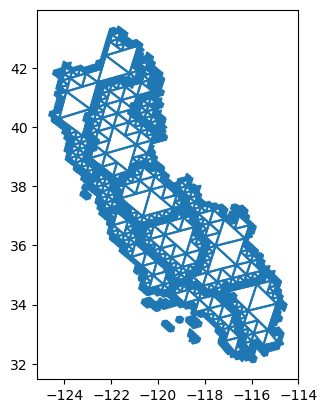

In [31]:
cali_watersheds.plot()

In [ ]:
# Events intertsecting San Joaquin
sj_sids = cali_watersheds[cali_watersheds.name=='San Joaquin'].sids.iloc[0]
intersects = features.stare_intersects(sj_sids, n_workers=60)
features[intersects].label.unique()

array([86], dtype=int32)

In [81]:
intersect = features[intersects]
intersect.stare_dissolve()

array([3247095331334127623, 3247130515706216455, 3247165700078305288, ...,
       3597505289059827721, 3597509687106338825, 3597511886129594377])

In [62]:
event = features[features.label==86]
dissolved_sids = event.stare_dissolve(n_workers=600)
dissolved_event = starepandas.STAREDataFrame(sids=[dissolved_sids])
trixels = dissolved_event.make_trixels(n_workers=600, wrap_lon=False)
dissolved_event.set_trixels(trixels, inplace=True)
dissolved_event = dissolved_event.split_antimeridian()

In [43]:
bm = rasterio.open('data/BlueMarbleNG-TB_2004-12-01_rgb_3600x1800.TIFF')
bm = bm.read()
bm = numpy.transpose(bm, (1, 2, 0))

In [ ]:
subset.plot(ax=ax, zorder=1, linewidth=0.0, column='label', cmap=cm, alpha=0.9)
    bounds = subset.set_geometry(subset.boundary)
    bounds.plot(ax=ax, zorder=1, linewidth=0.05, color='k', alpha=0.9)
    bounds.plot(ax=ax, zorder=1, linewidth=0.025, column='label', cmap=cm, alpha=0.5)

(20.0, 60.0)

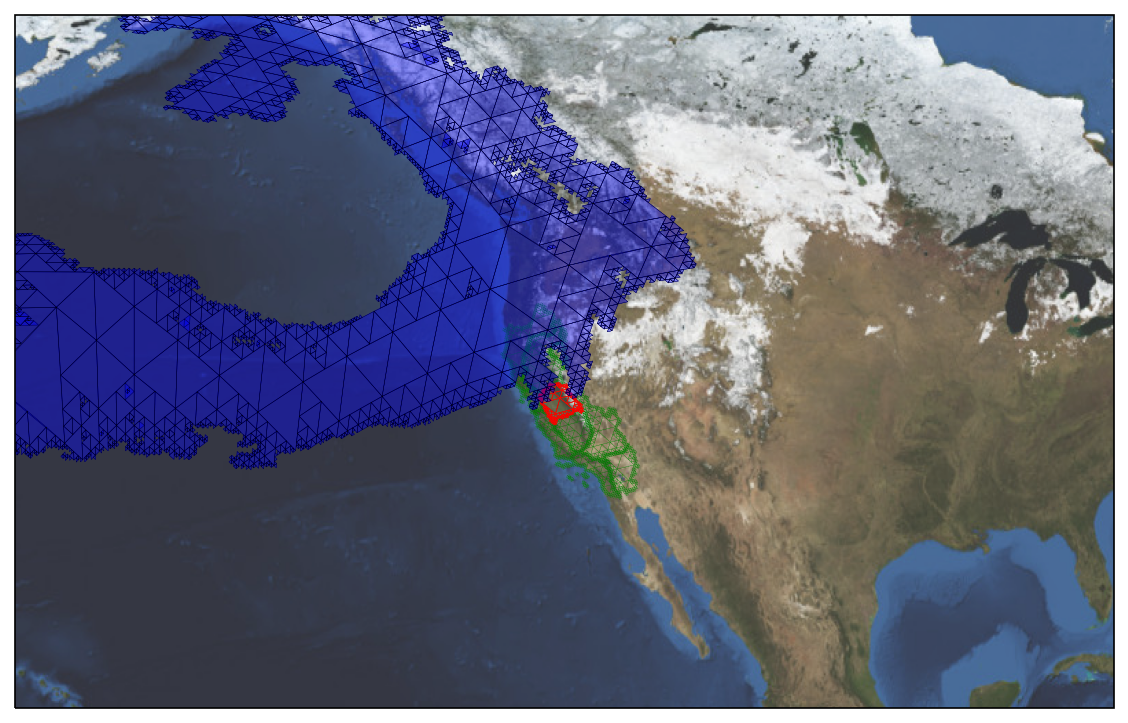

In [91]:
proj = cartopy.crs.PlateCarree()
opts = {'projection': proj}

fig, ax = plt.subplots(figsize=(12, 6), dpi=150, subplot_kw=opts)

basemap = ax.imshow(bm, extent=[-180, 180, -90, 90], alpha=0.8, transform=proj)
dissolved_event.plot(ax=ax, color='blue', transform=proj, linewidth=0.2, zorder=2)
dissolved_event.plot(ax=ax, color='blue', transform=proj, linewidth=0.05, zorder=2, boundary=False, alpha=0.4)
dissolved_event.plot(ax=ax, color='black', transform=proj, linewidth=0.2, zorder=2, boundary=True, alpha=0.9)

cali_watersheds.plot(ax=ax, color='green', transform=proj, linewidth=0.1, zorder=1)
cali_watersheds[cali_watersheds.name=='San Joaquin'].plot(ax=ax, color='red', transform=proj, linewidth=0.3, zorder=1)

ax.set_xlim(-160, -80)
ax.set_ylim(20, 60)

In [ ]:
start = datetime.datetime.now()

# Load US States

In [4]:
!wget https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip

--2022-09-05 23:02:05--  https://www2.census.gov/geo/tiger/TIGER2019/STATE/tl_2019_us_state.zip
Resolving www2.census.gov (www2.census.gov)... 23.48.216.173, 2600:1406:1a:280::208c, 2600:1406:1a:281::208c
Connecting to www2.census.gov (www2.census.gov)|23.48.216.173|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘tl_2019_us_state.zip.2’

tl_2019_us_state.zi     [       <=>          ]   8.90M  6.12MB/s    in 1.5s    

2022-09-05 23:02:07 (6.12 MB/s) - ‘tl_2019_us_state.zip.2’ saved [9332961]



In [5]:
states = geopandas.read_file('tl_2019_us_state.zip')

In [6]:
states = starepandas.STAREDataFrame(states)
sids = states.make_sids(n_workers=50, resolution=10)
states.set_sids(sids, inplace=True)
trixels = states.make_trixels(n_workers=50, wrap_lon=False)
states.set_trixels(trixels, inplace=True)
states.split_antimeridian(inplace=True)

In [7]:
alabama = states[states['NAME']=='Alabama']
alabama_sids = alabama.sids.iloc[0]

<AxesSubplot:>

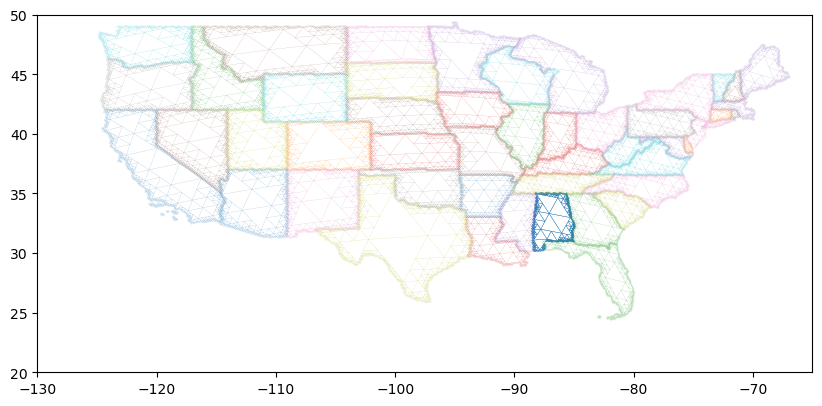

In [10]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot()

ax.set_xlim(-130, -65)
ax.set_ylim(20, 50)

alabama.plot(ax=ax, linewidth=0.2)
states.plot(ax=ax, column='NAME', linewidth=0.1, alpha=0.4)

# Pull out events intersecting Alabama

In [11]:
intersects = features.stare_intersects(alabama_sids, n_workers=60)
features[intersects].label.unique()

array([ 30,  67,  93,  98, 100], dtype=int32)

# Inspecting the first event (17)

In [13]:
event = features[features.label==30]

<AxesSubplot:>

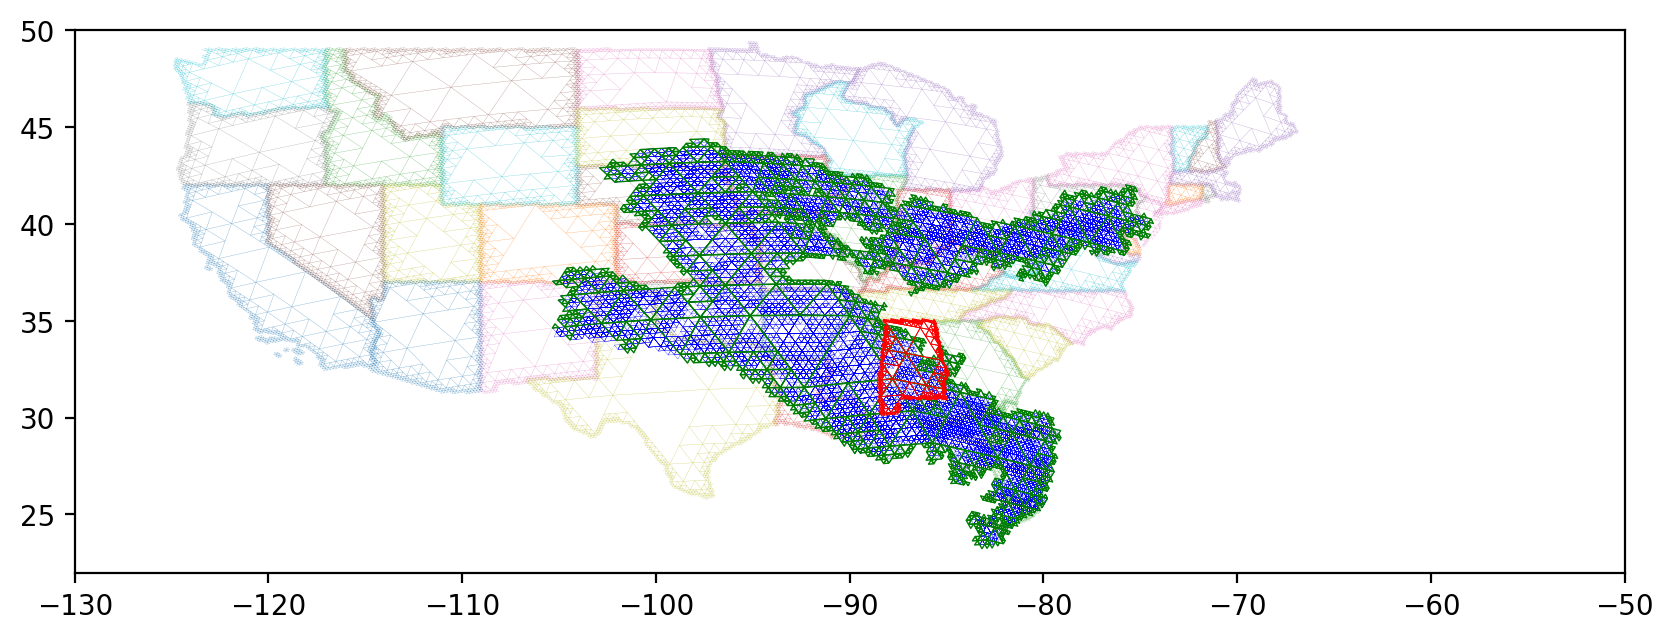

In [15]:
fig = plt.figure(figsize=(10, 10), dpi=200)
ax = fig.add_subplot()

ax.set_xlim(-130, -65+15)
ax.set_ylim(22, 50)

dissolved_sids = event.stare_dissolve()
dissolved_event = starepandas.STAREDataFrame(sids=[dissolved_sids])
trixels = dissolved_event.make_trixels()
dissolved_event.set_trixels(trixels, inplace=True)

states.plot(ax=ax, column='NAME', linewidth=0.1, alpha=0.4, zorder=1)
event.plot(ax=ax, linewidth=0.1, color='blue', zorder=2)
dissolved_event.plot(ax=ax, linewidth=0.5, color='green', zorder=3)
alabama.plot(ax=ax, color='r', linewidth=0.3, zorder=4)

# Calculating precip 

## Precipfor the whole event

In [36]:
tot_precip = event.tot_precip.sum()
print(f'Total Precip: {tot_precip:,.2f} cubic meters')

Total Precip: 61,980,755,210.15 cubic meters


## Getting timeframes of the event that intersected Alabama

In [37]:
intersects = event_17.stare_intersects(alabama_sids)
over_alabama = event_17.reset_index()[intersects]

## Getting the cells/sids/trixels that intersect Alabama

In [38]:
over_alabama['in'] =  over_alabama['sids'].apply(lambda row: pystare.intersects(alabama_sids, row))

## Calculating Total Precip over alabama

In [15]:
def calc_tot_precip(row):
    return (row['cell_areas']*row['precips']/1000/2*row['in']).sum()
    
over_alabama['precip_in_alabama'] = over_alabama.apply(lambda row: calc_tot_precip(row), axis=1)

In [16]:
alabama_precip = over_alabama['precip_in_alabama'].sum()
alabama_precip_share = alabama_precip/tot_precip * 100
print(f'Share of event 17 in Alabama is {alabama_precip_share:2.2f} %')

Share of event 17 in Alabama is 4.38 %


In [17]:
print(f'Total Precip: {alabama_precip:,.2f} cubic meters')

Total Precip: 2,716,062,957.69 cubic meters


# Total Runtime

In [18]:
print(datetime.datetime.now()-start)

0:01:38.326644


In [19]:
event_17.timestamp.max()-event_17.timestamp.min()

Timedelta('2 days 12:30:00')

In [20]:
over_alabama.timestamp.max()-over_alabama.timestamp.min()

Timedelta('1 days 18:30:00')

# Creating time sliced overlaps

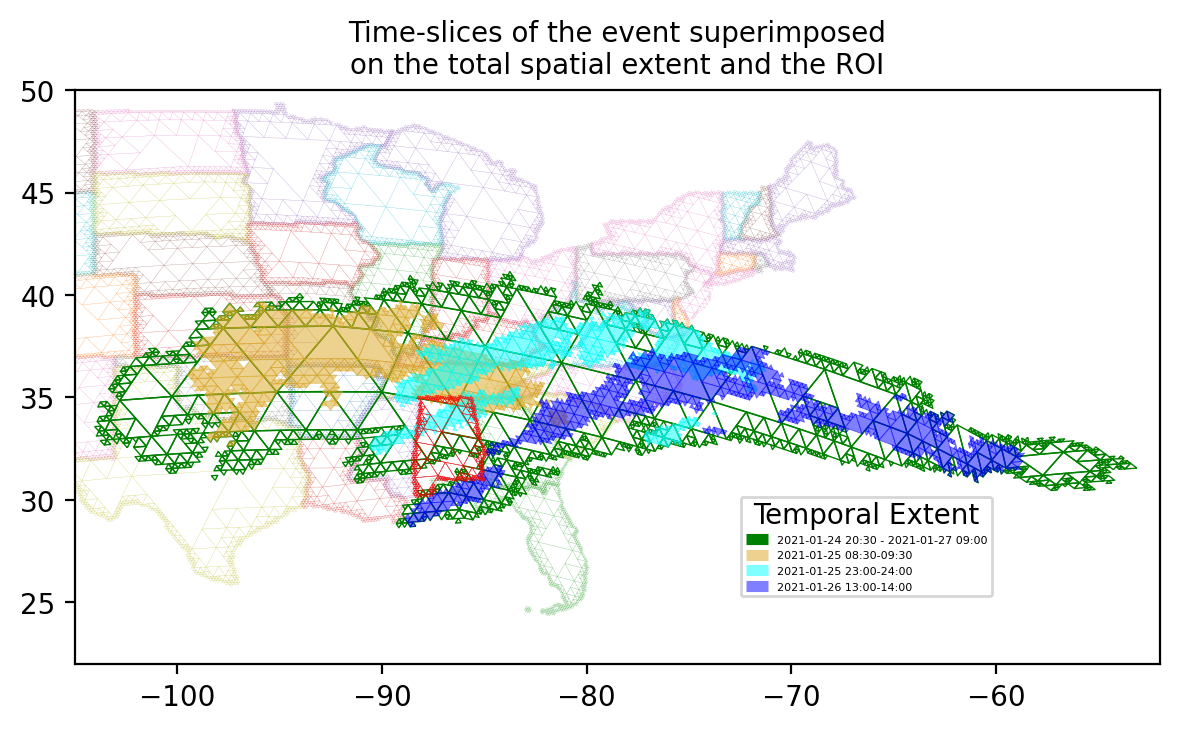

In [21]:
fig = plt.figure(figsize=(7, 7), dpi=200)
ax = fig.add_subplot()

ax.set_xlim(-105, -65+13)
ax.set_ylim(22, 50)

states.plot(ax=ax, column='NAME', linewidth=0.1, alpha=0.4)

dissolved_sids = event_17.stare_dissolve()
dissolved_event = starepandas.STAREDataFrame(sids=[dissolved_sids])

trixels = dissolved_event.make_trixels()
dissolved_event.set_trixels(trixels, inplace=True)

dissolved_event.plot(ax=ax, zorder=2, linewidth=0.5, color='g', label='2021-01-24 20:30 - 2021-01-27 09:00')

s_ = event_17.iloc[numpy.where((pandas.Timestamp('2021-01-25 08:30:00') <= event_17.timestamp) & (event_17.timestamp <= pandas.Timestamp('2021-01-25 09:30:00')))]
s_ = s_.stare_dissolve(by='label')
s_.set_trixels(s_.make_trixels(), inplace=True)
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='goldenrod', alpha=0.5, label='2021-01-25 08:30-09:30', boundary=False)
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='goldenrod', alpha=0.5, label='2021-01-25 08:30-09:30', boundary=True)

s_ = event_17.iloc[numpy.where((pandas.Timestamp('2021-01-25 23:00:00') <= event_17.timestamp) & (event_17.timestamp <= pandas.Timestamp('2021-01-26 00:00:00')))]
s_ = s_.stare_dissolve(by='label')
s_.set_trixels(s_.make_trixels(), inplace=True)
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='cyan', alpha=0.5, label='2021-01-25 23:00-24:00', boundary=False)
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='cyan', alpha=0.5, label='2021-01-25 23:00-24:00', boundary=True)

s_ = event_17.iloc[numpy.where((pandas.Timestamp('2021-01-26 13:00:00') <= event_17.timestamp) & (event_17.timestamp <= pandas.Timestamp('2021-01-26 14:00:00')))]
s_ = s_.stare_dissolve(by='label')
s_.set_trixels(s_.make_trixels(), inplace=True)
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='b', alpha=0.5, label='2021-01-26 13:00-14:00', boundary=False)
s_.plot(ax=ax, zorder=3, linewidth=0.3, color='b', alpha=0.5, label='2021-01-26 13:00-14:00', boundary=True)

alabama.plot(ax=ax, zorder=10, color='r', linewidth=0.2,alpha=0.7)

leg = plt.legend(bbox_to_anchor=(0.85,0.3), markerscale=20, title='Temporal Extent', prop={'size': 4})
for l in leg.get_lines():
    l.set_linewidth(4)

plt.title('Time-slices of the event superimposed\non the total spatial extent and the ROI',fontsize=10)
plt.show()

In [22]:
s = pystare.spatial_coerce_resolution(numpy.array(dissolved_sids), 4)
s = pystare.spatial_clear_to_resolution(s)

In [23]:
pattern='S1\.1C..*\.2021012[4567].*'
s1 = starepandas.read_pods(pod_root='/tablespace/xcal/starepods/', sids=pystare.int2hex(s), pattern=pattern, add_podname=True)

In [24]:
s1.groupby_sids('stare', inplace=True)
s1.set_trixels(s1.make_trixels(n_workers=500, wrap_lon=False), inplace=True)

AttributeError: 'STAREDataFrame' object has no attribute 'groupby_sids'

In [ ]:
s1

In [ ]:
s1.groupby(''